# 기온 예측문제

## 데이터 불러오기
  - p379

In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-08-30 04:01:45--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 16.182.70.240, 52.217.47.142, 52.217.90.14, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|16.182.70.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  19.3MB/s    in 0.7s    

2023-08-30 04:01:46 (19.3 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


- 독일 예나 날씨 데이터셋 확인

In [2]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


## 데이터 파싱

In [3]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))

temperature.shape, raw_data.shape

((420451,), (420451, 14))

In [4]:
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

In [6]:
temperature[0], raw_data[0]

(-8.02,
 array([ 9.96520e+02, -8.02000e+00,  2.65400e+02, -8.90000e+00,
         9.33000e+01,  3.33000e+00,  3.11000e+00,  2.20000e-01,
         1.94000e+00,  3.12000e+00,  1.30775e+03,  1.03000e+00,
         1.75000e+00,  1.52300e+02]))

## 시각화

- 전체 온도

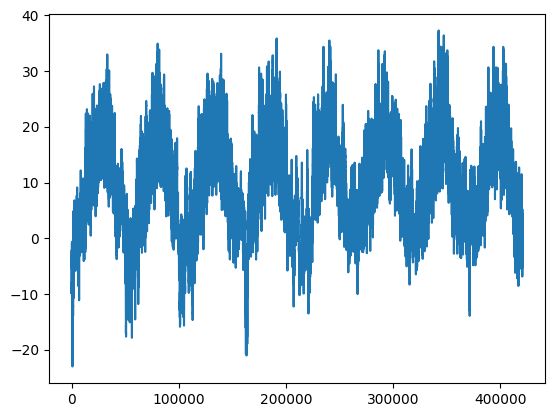

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(range(len(temperature)), temperature)
plt.show()

- 교재 해석 : 이 그래프에서 일별 주기성을 볼 수 있다. 마지막 4일간 데이터를 보면 확실하다.
- 10일의 기간은 아주 추운 겨울에 해당
- 예측 알고리즘
  - 선택 1 : 통계 방법
  - 선택 2 : 머신러닝
  - 선택 3 : 딥러닝

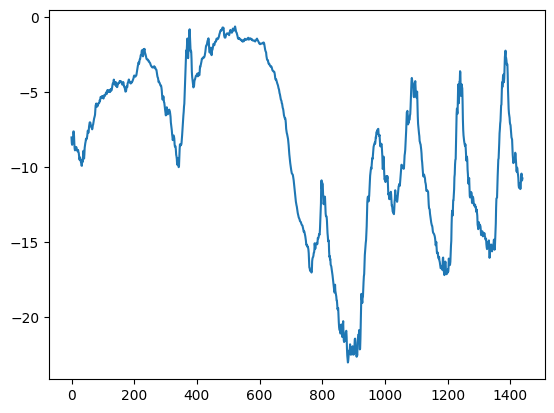

In [8]:
fig, ax = plt.subplots()
plt.plot(range(1440), temperature[:1440])
plt.show()

## 데이터 준비

In [9]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


- p383

In [11]:
# Data Leakage:
# 훈련 데이터와 테스트 데이터 정보가 섞이면 안됨
# 테스트 데이터의 정보를 모름 ---> 어떻게 평균을 구할까?
# 정규화는 해야 하니까, 훈련 데이터 정보를 테스트 데이터에 적용

mean = raw_data[:num_train_samples].mean(axis=0) # 훈련데이터의 평균 가져옴
raw_data -= mean

std = raw_data[:num_train_samples].std(axis=0) # 훈련데이터의 표준편차 가져옴
raw_data /= std

## timeseries_dataset_from_array
- tensorflow가 원하는 방식으로 데이터셋을 정렬
- raw_data와 temperature 배열만 메모리에 유지하고,
- 샘플 수정

In [12]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


## 훈련, 검증, 테스트 데이터셋 만들기
- 시간당 하나의 데이터가 샘플링된다

In [13]:
sampling_rate = 6 # 시간당 6개의 데이터 포인트가 찍히고(10분 단위), 시간당 하나의 데이터 포인트가 샘플링 됨
sequence_length = 120 # 이전 120시간동안의 데이터 사용
delay = sampling_rate * (sequence_length + 24 - 1) # 24시간 후의 온도
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

- 훈련 데이터셋의 배치크기 확인

In [15]:
for samples, targets in train_dataset:
  print('샘플 크기 :', samples.shape) # 256개의 샘플로 이루어진 배치로 각 샘플은 연속된 120시간의 입력 데이터
  print('타깃 크기 :', targets.shape) # 256개의 타깃 온도에 해당하는 배열
  break

샘플 크기 : (256, 120, 14)
타깃 크기 : (256,)


## 평가지표 만들기
- MAE 평가지표를 만들자

In [16]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"검증 MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"테스트 MAE: {evaluate_naive_method(test_dataset):.2f}")

검증 MAE: 10.28
테스트 MAE: 10.40


## 기본적인 머신러닝 모델
- 밀집연결

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

- 1D 합성곱 모델
- 이 모델이 밀집연결 모델보다 성능이 안 좋은 이유
  - p392
  - 이 데이터는 순서가 많이 중요함
  - 어제 데이터가 5일 전 데이터보다 내일 온도를 예측하는데 훨씬 유용하다! CNN 모델은 이런 사실을 활용할 수 없고, MaxPooling, AveragePooling층 때문에 순서 정보가 많이 삭제 됨.

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

## LSTM 모델

In [22]:
sequence_length,  raw_data.shape[-1]

(120, 14)

In [23]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1])) # input
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 lstm (LSTM)                 (None, 16)                1984      
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2,001
Trainable params: 2,001
Non-trainable params: 0
_________________________________________________________________


In [28]:
callbacks = [
    keras.callbacks.ModelCheckpoint('jena_lstm.keras', save_best_only=True)
]

model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(
    train_dataset,
    epochs = 10,
    validation_data = val_dataset,
    callbacks=callbacks
)

Epoch 1/10
819/819 [==============================] - 57s 67ms/step - loss: 9.7724 - mae: 2.4349 - val_loss: 9.6256 - val_mae: 2.4129
Epoch 2/10
819/819 [==============================] - 48s 58ms/step - loss: 9.2828 - mae: 2.3745 - val_loss: 9.3173 - val_mae: 2.3785
Epoch 3/10
819/819 [==============================] - 55s 66ms/step - loss: 8.9246 - mae: 2.3318 - val_loss: 9.3557 - val_mae: 2.3795
Epoch 4/10
819/819 [==============================] - 55s 67ms/step - loss: 8.7503 - mae: 2.3081 - val_loss: 9.4484 - val_mae: 2.3911
Epoch 5/10
819/819 [==============================] - 49s 59ms/step - loss: 8.5565 - mae: 2.2832 - val_loss: 9.3625 - val_mae: 2.3914
Epoch 6/10
819/819 [==============================] - 47s 57ms/step - loss: 8.3664 - mae: 2.2564 - val_loss: 9.2682 - val_mae: 2.3822
Epoch 7/10
819/819 [==============================] - 49s 59ms/step - loss: 8.2120 - mae: 2.2355 - val_loss: 9.4701 - val_mae: 2.4039
Epoch 8/10
819/819 [==============================] - 55s 67ms

In [30]:
model = keras.models.load_model('jena_lstm.keras')
print(f'테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}')

405/405 [==============================] - 16s 37ms/step - loss: 10.4573 - mae: 2.5388
테스트 MAE: 2.54


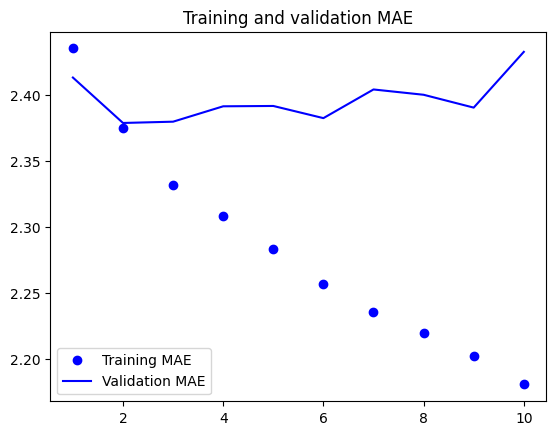

In [29]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

## 넘파이로 구현한 RNN

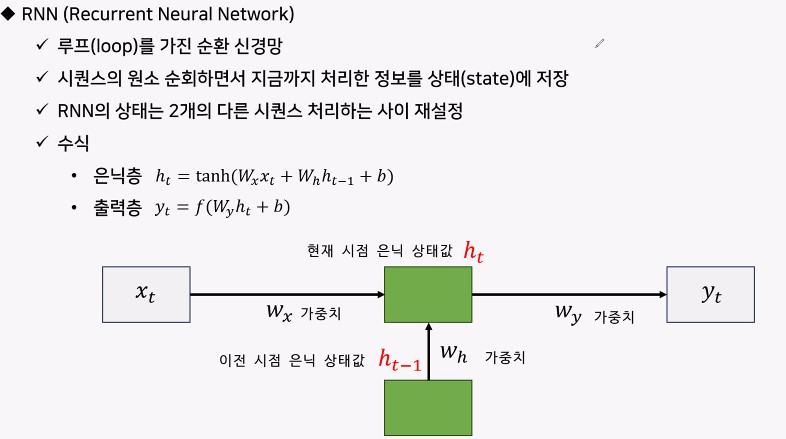

In [35]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64

inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,)) # 이전 출력의 정보를 담고 있음

# 가중치 행렬
W = np.random.random((output_features, input_features)) # 가중치 Wx
U = np.random.random((output_features, output_features)) # 가중치 Wh
b = np.random.random((output_features,)) # 가중치 Wy

successive_outputs = []
for input_t in inputs:
  output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
  successive_outputs.append(output_t)
  state_t = output_t # RNN 코드의 핵심, 현재의 출력을 state_t에 저장함으로써 다음 출력에 활용 가능하게 함

final_output_sequence = np.stack(successive_outputs, axis=0)
final_output_sequence

array([[0.99999999, 0.99999994, 0.99999994, ..., 0.99999996, 0.99999984,
        0.99999961],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       ...,
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ]])